# 2. Mosaicking with Linmos

## The Data - RACS0830-68A


In [1]:
# This is done for keeping the notebook clean, remove this if you are using this notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
# https://data.csiro.au/collections/domain/casdaSkymap/summary/catalogue/RACS_0730-68A_component_53b/continuum_component
# https://data.csiro.au/domain/casdaObservation/results?dataProducts=%5B%7B%22dataProduct%22%3A%22CATALOGUE%22%7D,%7B%22dataProduct%22%3A%22IMAGE_CUBE%22%7D,%7B%22dataProduct%22%3A%22IMAGE_CUBE_ANCILLARY%22%7D,%7B%22dataProduct%22%3A%22SPECTRUM%22%7D,%7B%22dataProduct%22%3A%22MEASUREMENT_SET%22%7D%5D&facets=%5B%5D&showRejected=false&releasedFilter=released&includeCommensalProjects=false&showFacets=true&coneSearches=%5B%7B%22rightAscension%22%3A%2208%3A16%3A36.828%22,%22declination%22%3A%22-70%3A39%3A55.573%22,%22radius%22%3A2%7D%5D&objectName=J081636-703955

# 2MASX J08161181-7039447

SB12486_fits = "AS110/RACS0830-68A/image.i.SB12486.cont.RACS_0830-68A.linmos.taylor.0.restored.fcor.fits"

section_fits = "SB12486_section.fits"


In [3]:
# Helper to plot data

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import os

%matplotlib inline

def plot_fits(hdu, gamma=0.3, vmin=0, vmax=None):
    wcs = WCS(hdu.header, naxis=2)
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, projection=wcs)

    if vmax is not None:
        im = ax.imshow(hdu.data[0,0,:,:], origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)        
    else:
        im = ax.imshow(hdu.data[0,0,:,:], origin='lower', cmap='viridis', norm=mcolors.PowerNorm(gamma))
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.set_autoscale_on(False)
    ax.set_title("image")
    plt.colorbar(im, ax=ax)

    plt.tight_layout(pad=3, w_pad=2, h_pad=2)
    plt.show()

In [4]:
file = SB12486_fits

SB12486_hdu = fits.open(file)[0]
SB12486_data = SB12486_hdu.data

SB12486_data.shape

(1, 1, 14533, 14537)

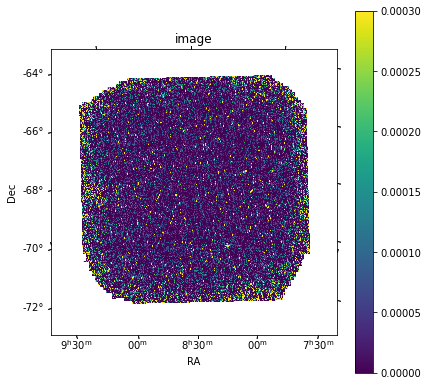

In [5]:
plot_fits(SB12486_hdu, vmin=0, vmax=300e-6)

## Extracting a section of the Sky

In [6]:
def split(hdu, xst, xen, yst, yen):
    ref = SkyCoord(hdu.header["CRVAL1"], hdu.header["CRVAL2"], unit='deg')
    ref_px_x, ref_px_y = hdu.header["CRPIX1"], hdu.header["CRPIX2"]

    delta_1 = hdu.header["CDELT1"] * u.deg
    delta_2 = hdu.header["CDELT2"] * u.deg

    w = WCS(hdu.header, naxis=2)

    xsize = xen - xst
    ysize = yen - yst

    coord = w.pixel_to_world(xst, yst)
    print(ref.ra.hms, ref.dec.hms)
    print(coord.ra.hms, coord.dec.hms)

    new_data = hdu.data[:,:,xst:xen,yst:yen]
    new_wcs = WCS(naxis=4)

    new_wcs.wcs.crpix = [0, 0, 1, 1]
    new_wcs.wcs.cunit = ['deg', 'deg', 'Hz', '']
    new_wcs.wcs.cdelt = np.array([delta_1.value, delta_2.value, 1, 1])
    new_wcs.wcs.crval = [coord.ra.deg, coord.dec.deg, 1, 1]
    new_wcs.wcs.ctype = ['RA---SIN', 'DEC--SIN', 'FREQ', 'STOKES']

    new_hdu = fits.PrimaryHDU(data=new_data, header=new_wcs.to_header())

    return new_hdu


hms_tuple(h=8.0, m=24.0, s=21.576000000005138) hms_tuple(h=-4.0, m=-32.0, s=-33.717333333604955)
hms_tuple(h=8.0, m=30.0, s=28.027292722806152) hms_tuple(h=-4.0, m=-34.0, s=-45.23910156480014)


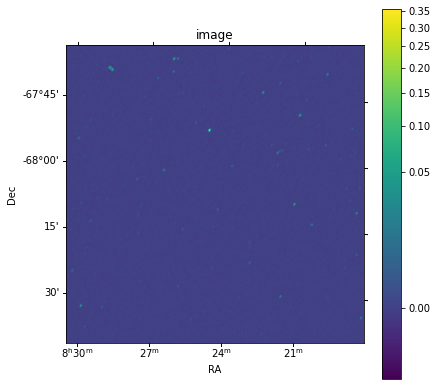

In [7]:
hdu = SB12486_hdu
ref = SkyCoord(hdu.header["CRVAL1"], hdu.header["CRVAL2"], unit='deg')
ref_x, ref_y = int(hdu.header["CRPIX1"]), int(hdu.header["CRPIX2"])
delta_1 = hdu.header["CDELT1"] * u.deg
delta_2 = hdu.header["CDELT2"] * u.deg
w = WCS(hdu.header, naxis=2)

hdu_split = split(SB12486_hdu, 7223, 8847, 7334, 8958)
plot_fits(hdu_split, 0.3)

In [8]:
def chunk(offset_x, offset_y):
    st_x, en_x = int(ref_x + offset_x), int(ref_x + offset_x + 1024)  
    st_y, en_y = int(ref_y + offset_y), int(ref_y + offset_y + 1024)

    coord = w.pixel_to_world(st_x, st_y)
#     print("x: ", st_x, "to: ", en_x)
#     print("y: ", st_y, "to: ", en_y)

    new_data = hdu.data[:,:,st_x:en_x,st_y:en_y]
    new_wcs = WCS(naxis=4)

    new_wcs.wcs.crpix = [0, 0, 1, 1]
    new_wcs.wcs.cunit = ['deg', 'deg', 'Hz', '']
    new_wcs.wcs.cdelt = np.array([delta_1.value, delta_2.value, 1, 1])
    new_wcs.wcs.crval = [coord.ra.deg, coord.dec.deg, 1, 1]
    new_wcs.wcs.ctype = ['RA---SIN', 'DEC--SIN', 'FREQ', 'STOKES']

    new_hdu = fits.PrimaryHDU(data=new_data, header=new_wcs.to_header())

    return new_hdu

chunks = [
    chunk(-800, -800),
    chunk(-800, -200),
    chunk(-200, -800),
    chunk(-200, -200),
]

files = [
    'SB12486_chunk_1',
    'SB12486_chunk_2',
    'SB12486_chunk_3',
    'SB12486_chunk_4',
]

fits_files = [file + '.fits' for file in files]

for idx, file in enumerate(fits_files):
    # clear this as astropy will through an error if it doesn't
    os.system(f"rm {file}")
    chunks[idx].writeto(file)

### Viewing our files

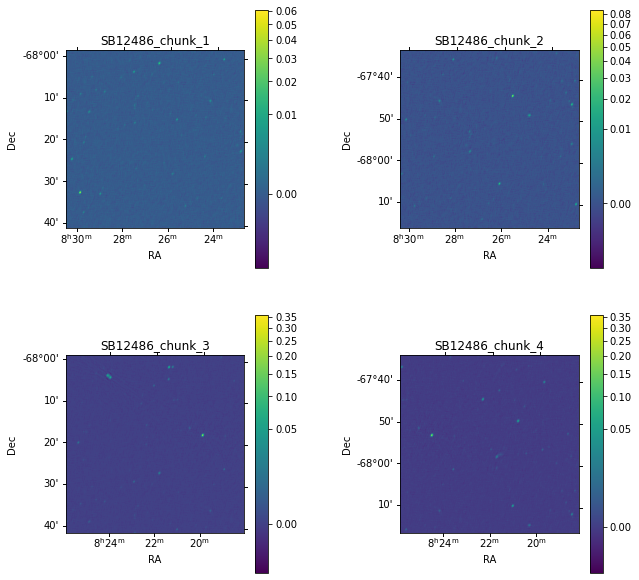

In [9]:
# Using one of the files to setup WCS projection
fig = plt.figure(figsize=(8, 8))

for i in range(2):
    for j in range(2):
        idx = 2 * i + j
        file = fits_files[idx]

        hdu = fits.open(file)[0]
        wcs = WCS(hdu.header, naxis=2)
        ax = plt.subplot(2, 2, idx+1, projection=wcs)

        im = ax.imshow(hdu.data[0,0,:,:], origin='lower', cmap='viridis', norm=mcolors.PowerNorm(0.3))
        ax.set_xlabel('RA')
        ax.set_ylabel('Dec')
        ax.set_autoscale_on(False)
        ax.set_title(files[idx])
        plt.colorbar(im, ax=ax)

plt.tight_layout(w_pad=10.3, h_pad=4.4, pad=0.5)
plt.show()


## Mosaicking with linmos

In [ ]:
from taitale import taitale_env

env = taitale_env(
    image = "csirocass/askapsoft",
    tag = "1.17.6-openmpi4"
)


In [10]:
from taitale.askap import linmos

mosaic = 'SB12486_combined_2.linmos.out'
mosaic_weight = 'SB12486_weight_combined_2.linmos.out'

linmos(
    env=env,
    args={
        "names": files,
        "weighttype": 'FromPrimaryBeamModel',
        "outname": mosaic,
        "outweight": mosaic_weight,
    }
)

Starting linmos
linmos complete


## Viewing our result

<IPython.core.display.Javascript object>


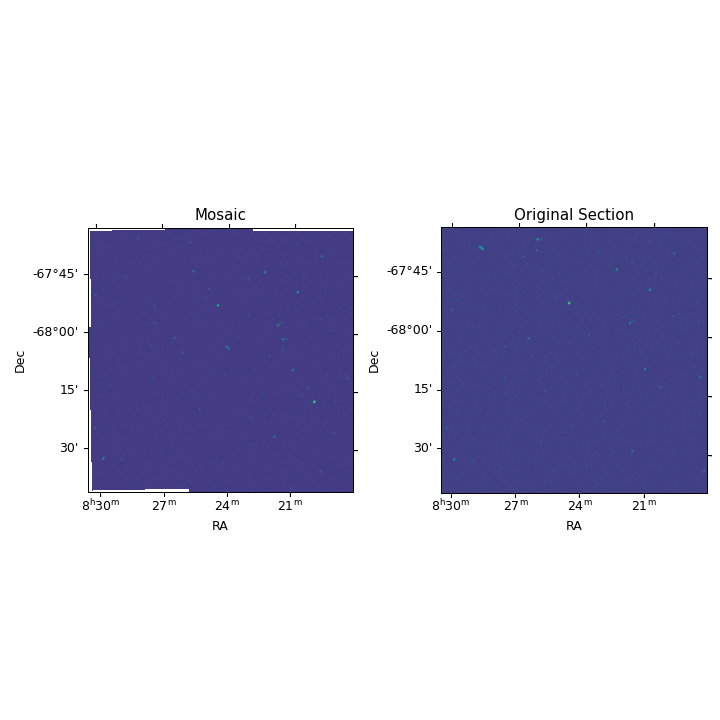

In [13]:
fig = plt.figure(figsize=[8, 8], tight_layout=dict(w_pad=6.0, h_pad=0))
plt.title("Comparison")

hdu = fits.open(mosaic+'.fits')[0]
wcs = WCS(hdu.header, naxis=2)

ax_1 = plt.subplot(1, 2, 1, projection=wcs)
im_1 = ax_1.imshow(hdu.data[0,0,:,:], origin='lower', cmap='viridis', norm=mcolors.PowerNorm(0.3))
ax_1.set_xlabel('RA')
ax_1.set_ylabel('Dec')
ax_1.set_title("Mosaic")
ax_1.set_autoscale_on(False)


wcs_split = WCS(hdu_split.header, naxis=2)

ax_2 = plt.subplot(1, 2, 2, projection=wcs_split)
im_2 = ax_2.imshow(hdu_split.data[0,0,:,:], origin='lower', cmap='viridis', norm=mcolors.PowerNorm(0.3))
ax_2.set_xlabel('RA')
ax_2.set_ylabel('Dec')
ax_2.set_autoscale_on(False)
ax_2.set_title("Original Section")

plt.show()

### Understanding how linmos combined our images

In the weights image you would see the central pixels having a weight of 4, corresponding to the location where our original 4 images had all overlapped. 


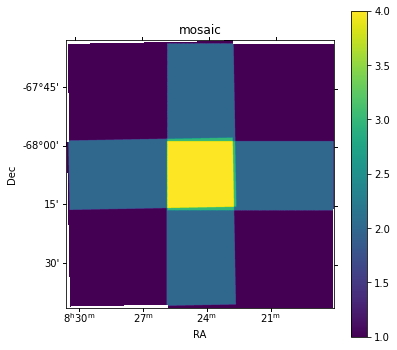

In [14]:
fig = plt.figure(figsize=(6, 6))

hdu = fits.open(mosaic_weight+'.fits')[0]
wcs = WCS(hdu.header, naxis=2)

ax = plt.subplot(111, projection=wcs)
im = ax.imshow(hdu.data[0,0,:,:], origin='lower', cmap='viridis')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
# ax.set_autoscale_on(False)

ax.set_title("mosaic")
plt.colorbar(im, ax=ax)
plt.show()